## PyTorch Layer 이해하기

### 예제 불러오기

In [ ]:
import torch
from torchvision import datasets, transforms

In [ ]:
torch.__version__

'1.7.0+cu101'

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

PyTorch DataLoader

* https://pytorch.org/docs/stable/data.html
* It represents a **Python iterable** over a dataset
*  PyTorch supports two different types of datasets:
  - map-style datasets
  - iterable-style datasets

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                   transform=transforms.Compose([
                      transforms.ToTensor()
                  ])),
    batch_size=1)

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
image, label = next(iter(train_loader))

In [ ]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

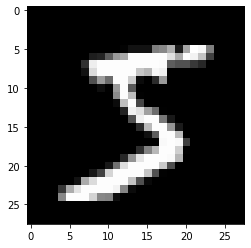

In [ ]:
plt.imshow(image[0, 0, :, :], 'gray')
plt.show()

### 각 Layer별 설명

* Layer를 쌓아 network를 구성하기 위한 준비
  - torch.nn: graph를 만들기 위한 basic building block을 묶어놓은 모듈
  - torch.nn.functional: torch.nn이 class인것과 달리 function 단위로 구성

[What is the difference between torch.nn and torch.nn.functional?](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597)

In [ ]:
import torch.nn as nn  # These are the basic building block for graphs; having weights
import torch.nn.functional as F  # max-pooling, activation
import torch.optim as optim  # a package implementing various optimization algorithms

#### Convolution

* in_channels: 받는 channel의 수
* out_channels: 내보내는 channel의 수
* kernel_size: kernel(weights)의 사이즈

In [ ]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)  # mnist dataset

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [ ]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

* weight 시각화를 위해 slice하고 numpy화

In [ ]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

* weight는 학습 가능한 상태, numpy로 변환 가능
* detach() method는 그래프에서 빼서 gradient에 영향을 받지 않음

In [ ]:
weight = weight.detach().numpy()

In [ ]:
weight.shape  # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

(20, 1, 5, 5)

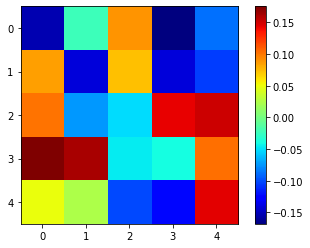

In [ ]:
plt.imshow(weight[0, 0, :, :], 'jet')
plt.colorbar()
plt.show()

* output 시각화를 위한 numpy 변환



In [ ]:
output_data = layer(image)

In [ ]:
output_data = output_data.data

In [ ]:
output = output_data.cpu().numpy()

In [ ]:
output.shape

(1, 20, 24, 24)

* input으로 사용한 이미지 numpy 변환

In [ ]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

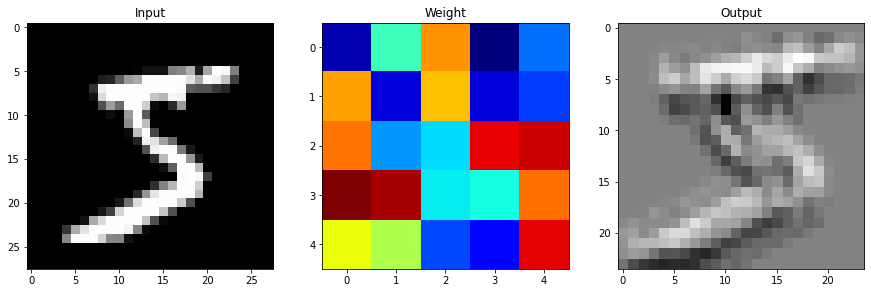

In [ ]:
plt.figure(figsize=(15, 30))
plt.subplot(131)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0, 0, :, :], 'jet')
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0, 0, :, :], 'gray')
plt.show()

#### Pooling

In [ ]:
image.shape

torch.Size([1, 1, 28, 28])

In [ ]:
pool = F.max_pool2d(image, 2, 2)  # https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
pool.shape

torch.Size([1, 1, 14, 14])

* MaxPool Layer는 weight가 없음; 바로 numpy로 변환 가능

In [ ]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [ ]:
image_arr.shape

(1, 1, 28, 28)

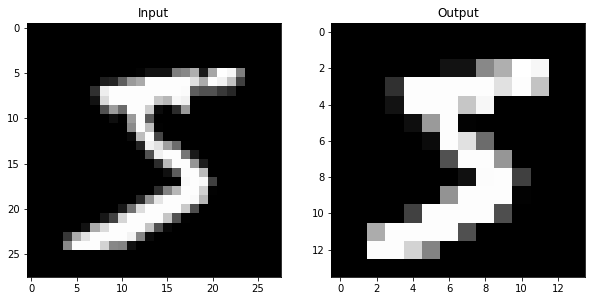

In [ ]:
plt.figure(figsize=(10, 15))
plt.subplot(121)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr), 'gray')
plt.show()

#### Linear

* nn.Linear는 2d가 아닌 1d만 입력

In [ ]:
flatten = image.view(1, 28 * 28)
flatten.shape

torch.Size([1, 784])

In [ ]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [ ]:
lin

tensor([[-0.1448,  0.4603,  0.2429, -0.1548, -0.1200, -0.2894, -0.1323,  0.0330,
         -0.2394,  0.1362]], grad_fn=<AddmmBackward>)

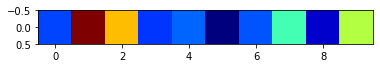

In [ ]:
plt.imshow(lin.detach().numpy(), 'jet')
plt.show()

#### Softmax

In [ ]:
with torch.no_grad():  # inner wieghts ignored
  flatten = image.view(1, 28 * 28)
  lin = nn.Linear(784, 10)(flatten)
  softmax = F.softmax(lin, dim=1)

In [ ]:
softmax

tensor([[0.1002, 0.0906, 0.0843, 0.1302, 0.0955, 0.0999, 0.0802, 0.1111, 0.1071,
         0.1008]])

In [ ]:
np.sum(softmax.numpy())

0.9999999

### Layer 쌓기



nn과 nn.functional의 차이점
* nn은 학습 파라미터가 담긴 것
* nn.functional은 학습 파라미터가 없는 것이라고 생각할 수 있음

In [52]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    # Feature Extraction
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)

    # Fully Connectd
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [53]:
model = Net()

In [54]:
result = model.forward(image)

In [55]:
result

tensor([[-2.3481, -2.2629, -2.3337, -2.3364, -2.3006, -2.3231, -2.2872, -2.2508,
         -2.3418, -2.2481]], grad_fn=<LogSoftmaxBackward>)